<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/GluonTS_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
#install GluonTS
#!pip install --upgrade mxnet~=1.7 gluonts

In [3]:
#metatrader 5 history file an timeframe is ok
df = pd.read_csv('/content/EURUSD_H1_202101040000_202201140100.csv')


In [4]:
#split mt5 into columns
df.columns=['header']
df = df.header.str.split('\t', expand=True)

In [5]:
#check the splits
df

,0,1,2,3,4,5,6,7,8
0,2021.01.04,00:00:00,1.22395,1.22398,1.22280,1.22341,521,0,0
1,2021.01.04,01:00:00,1.22336,1.22528,1.22304,1.22501,3052,0,0
2,2021.01.04,02:00:00,1.22501,1.22501,1.22386,1.22407,3534,0,0
3,2021.01.04,03:00:00,1.22407,1.22557,1.22398,1.22526,3564,0,0
4,2021.01.04,04:00:00,1.22526,1.22585,1.22495,1.22538,3348,0,0
...,...,...,...,...,...,...,...,...,...
6445,2022.01.13,21:00:00,1.14588,1.14653,1.14576,1.14618,1934,0,0
6446,2022.01.13,22:00:00,1.14615,1.14624,1.14508,1.14523,1970,0,0
6447,2022.01.13,23:00:00,1.14523,1.14555,1.14509,1.14539,775,0,0
6448,2022.01.14,00:00:00,1.14531,1.14569,1.14531,1.14544,652,0,10


In [6]:
#merge date and time to convert object to datetime to use as GluonTS index
selected_columns = df[[0,1,5]]
new_df = selected_columns.copy()
print(new_df)

               0         1        5
0     2021.01.04  00:00:00  1.22341
1     2021.01.04  01:00:00  1.22501
2     2021.01.04  02:00:00  1.22407
3     2021.01.04  03:00:00  1.22526
4     2021.01.04  04:00:00  1.22538
...          ...       ...      ...
6445  2022.01.13  21:00:00  1.14618
6446  2022.01.13  22:00:00  1.14523
6447  2022.01.13  23:00:00  1.14539
6448  2022.01.14  00:00:00  1.14544
6449  2022.01.14  01:00:00  1.14565

[6450 rows x 3 columns]


In [7]:
new_df['date_time_index'] = df[0] +' '+ df[1]
new_df = new_df.drop(columns = [0,1])

In [8]:
new_df = new_df.rename(columns={5:'price'})

In [9]:
#convert mt5 object formats to datetime and float
df2 = new_df[['date_time_index','price']]
df2['date_time_index'] = pd.to_datetime(df2['date_time_index'])
df2['price'] = df2['price'].astype(float, errors = 'raise')
df2 = df2.set_index('date_time_index')
print(df2)

                       price
date_time_index             
2021-01-04 00:00:00  1.22341
2021-01-04 01:00:00  1.22501
2021-01-04 02:00:00  1.22407
2021-01-04 03:00:00  1.22526
2021-01-04 04:00:00  1.22538
...                      ...
2022-01-13 21:00:00  1.14618
2022-01-13 22:00:00  1.14523
2022-01-13 23:00:00  1.14539
2022-01-14 00:00:00  1.14544
2022-01-14 01:00:00  1.14565

[6450 rows x 1 columns]


In [10]:
#check it is done
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6450 entries, 2021-01-04 00:00:00 to 2022-01-14 01:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6450 non-null   float64
dtypes: float64(1)
memory usage: 100.8 KB


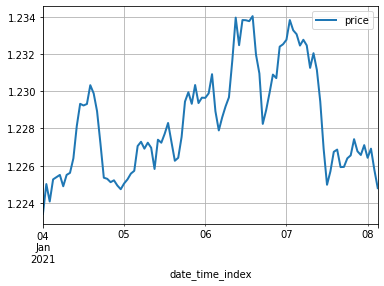

In [11]:
#print the data range from above
import matplotlib.pyplot as plt
df2[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [12]:
#import Gluon
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [13]:
#choose data range to train
training_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price["2021-01-01 00:00:00":"2022-01-14 00:00:00"]}], 
    freq = "1H"
    )

In [14]:
#import model 
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [ ]:
#train model
estimator = DeepAREstimator(freq="1H", prediction_length=24, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#choose data range to predict
test_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price["2022-01-14 00:00:00":"2022-01-14 01:00:00"]}],
    freq = "1H"
)

In [ ]:
#plot prediction graph
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[1.0, 5.0])
plt.grid(which='both')